# Classification - Loan Eligibility Prediction


In this project, we'll create a classification model on the credit risk dataset to identify the credible clients of a financial company.

----------------
## Context: 
----------------

The risk of loss due to non-repayment of the borrower's principal and interest is called credit risk. In fact, the lender uses the interest paid on the loan to offset the risk of potential losses. Failure of the borrower to pay their obligations could cause problems in the lender's cash flow.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## Objective:
------------------

Our client is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, their customers first apply for a home loan, then the company validates the customer's eligibility for it. 

Now, the company wants to automate the loan eligibility process. They want to use the data of their past customers to provide a model for predicting whether the loan should be approved or not. This would help the company prevent potential losses, save time, and focus more on eligible customers.


--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# import xgboost as xgb

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn import metrics
# from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, recall_score

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [3]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- The data type of ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status is numeric. The rest of the features have an object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- The Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [5]:
data.Loan_ID.nunique()

614

- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

In [6]:
# Missing values
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Credit_History has the most number of missing values. Self_Employed, Dependents, Loan_Amount_Term, Gender, and Married have  missing values as well.

In [7]:
data['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

This shows that the targer column is imbalanced (there are 422 ones and 192 zeros).

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [8]:
data.drop(columns=['Loan_ID'], inplace=True)

In [9]:
data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

#### Summary Statistics for numerical columns

In [10]:
# Selecting numeric features 
# The outcome of the first lines will include the boolean features Credit_History & Loan_Status, which were respectively stored as float64 and int64.
num_cols = data.select_dtypes(include=np.number).columns.tolist() 
#or # num_cols = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
num_cols= list(set(num_cols) - set(['Credit_History', 'Loan_Status'])) #removing boolean features

# Summary statistics 
#summary_stats = data.describe().T #I didn't use this cause the result would contain the boolean variables (Credit_History & Loan_Status) that were disguised as numeric
summary_stats = data[num_cols].describe().T

# Adding the Range and Coefficient of Variation of each numeric variable to the summary table
summary_stats['range'] = summary_stats['max'] - summary_stats['min']
summary_stats['CV'] = summary_stats['std'] / summary_stats['mean']

display(summary_stats)

,count,mean,std,min,25%,50%,75%,max,range,CV
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0,41667.0,1.804938
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0,80850.0,1.130580
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0,700.0,0.625792
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0,468.0,0.190411


**Observations:**
- The maximum amounts of the ApplicantIncome, CoapplicantIncome, & LoanAmount variables are way higher than their 3rd quartiles. Data has outliers and is skewed to the right. 
- Even the Loan_Amount_Term maximum, although not as much as that of the other mentioned numerical values, is over a standard deviation above its 3rd quartile. The minimum value of this variable is 0, which doesn't make sense (to have a loan amount of zero!). Further investigation shows that there are 22 records that have a loan amount of 0.0 dollars in thousands (even if the amount was 49 dollars it would be still too low). These are probably wrong entries or missing values.
- The 1st, 2nd, and 3rd quartile of Loan_Amount_Term are all equal to 360 months. This variable's min of 12 months is way below the 1st quartile.
- Comparing these features with one another shows that they have different scales.
- ApplicantIncome, CoapplicantIncome, & LoanAmount show different levels of positive skewness.

In [11]:
data['LoanAmount'].value_counts()

0      22
120    20
110    17
100    15
160    12
       ..
9       1
146     1
145     1
142     1
700     1
Name: LoanAmount, Length: 204, dtype: int64

#### Number of unique values of each column

In [12]:
data.nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

#### Feature Engineering

In [13]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [14]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [15]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Displaying scatter plots

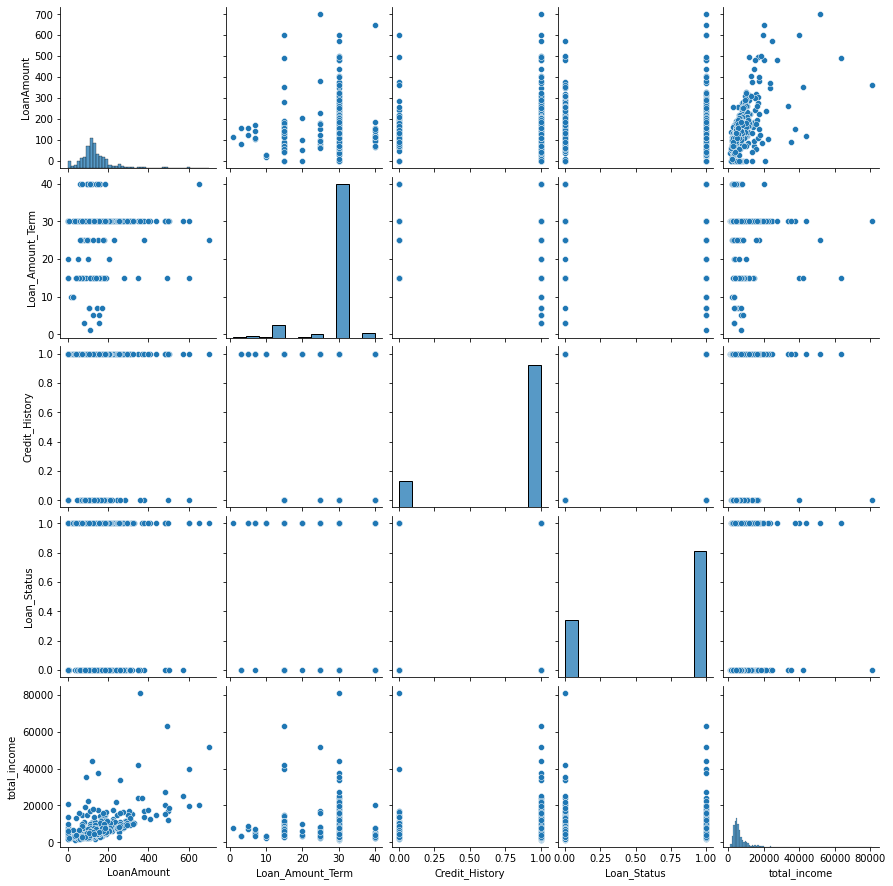

In [16]:
sns.pairplot(data=data)

#### Check the distribution and outliers for each column in the data

In [17]:
col2 = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

In [18]:
col2

['LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Loan_Status',
 'total_income']

In [21]:
# rows=2
# cols=3
# fig, ax=plt.subplots(nrows=rows,ncols=cols,figsize=(14,4))
# col=col2
# index=0
# for i in range(rows):
#     for j in range(cols):
#         sns.distplot(data[col[index]],ax=ax[i][j])
#         index=index+1
        
# plt.tight_layout()

LoanAmount
Skewness: 2.36


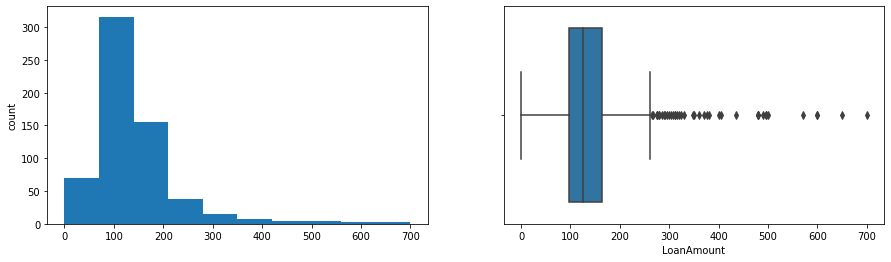

total_income
Skewness: 5.63


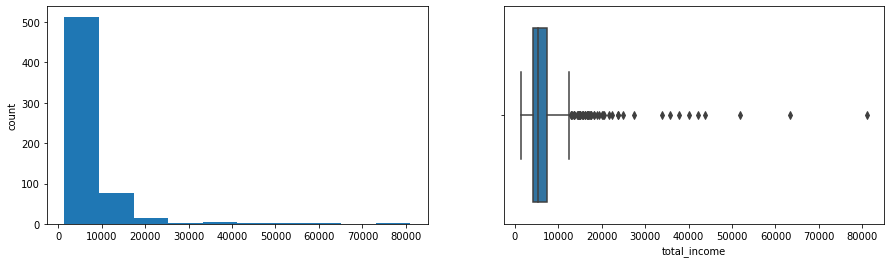

In [22]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skewness:',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both of the variables are highly skewed to the right and have many outliers, which was expected as the data contains different area types - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that the majority of values for total income are less than 10K.

Not, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

In [23]:
#Creating list of categorical columns
cat_col = data.select_dtypes(include=['object','category']).columns.tolist()
cat_col += ['Credit_History', 'Loan_Status'] #adding boolean features that were disguised as numeric

for col in cat_col:
    print(data[col].value_counts(normalize=True))
    print('-*-'*13)

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
-*--*--*--*--*--*--*--*--*--*--*--*--*-


**Observations:**
- The approved Loan_Status rate is 69% (unbalanced). 
- 81% of the applicants are male, so the Gender feature highly unbalances.
- 65% of the applicants are married.
- About 58% of the applicants don't have any dependents, while around 17% have one and another 17% have two dependents. Less than 9% have three or more dependents.
- Around 78% of the applicants have graduated (unbalanced).
- Over 14% of applicants are self-employed (unbalanced).
- The credit history of nearly 84% of the applicants meets the required guidelines (highly unbalanced).
- In over 29% of the cases the area the property pertaining to the loan belongs to a Rural, in less than 33% to a Semi-Urban, and in about 38% a Urban area.

#### Imputing missing values

In [24]:
# Identifying columns that have missing values
missing_cols=[col for col in data.columns if data[col].isnull().sum()!=0]

missing_cols

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'Loan_Amount_Term',
 'Credit_History']

In [25]:
#Imputing missing values with mode for the categorical variables 
for col in missing_cols:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [26]:
#Replacing 0's with null values in loanAmount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**Now that we are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

Let's check the relationship of loan amount with the total income.

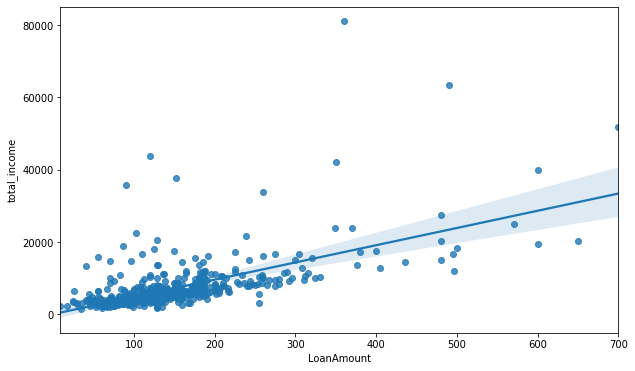

In [27]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relationship between total_income and LoanAmount, then that of total income with loan status.

<AxesSubplot:xlabel='total_income', ylabel='LoanAmount'>

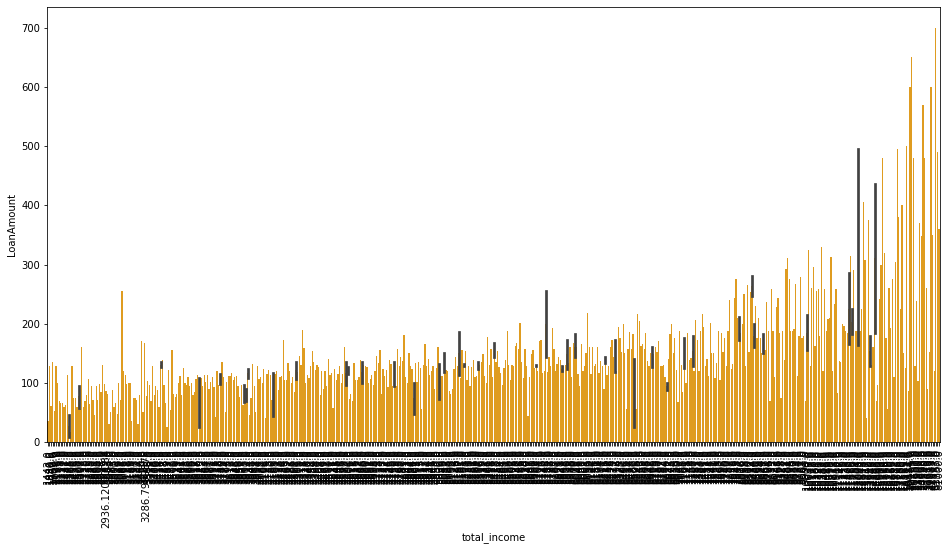

In [28]:
plt.figure(figsize=(16, 8))
plt.xticks(rotation=90)
sns.barplot(x='total_income',y='LoanAmount',color='orange',data=data)

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

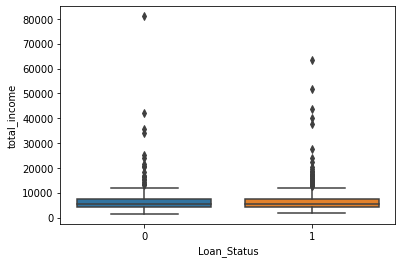

In [29]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

- There seems to be a positive relation between total_income and the LoanAmount.
- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

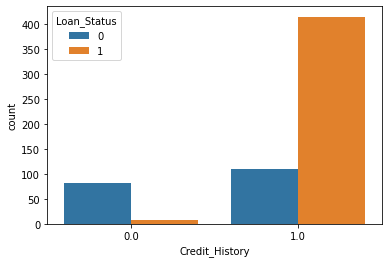

In [30]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

- The plot shows that credit history is an important factor while checking loan eligibility. Most customers whose loan was approved, even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

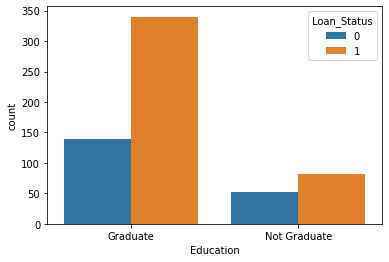

In [31]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

Based on their credit history, let's compare the chances of women vs men, when it comes to receiving loans.

<AxesSubplot:xlabel='Credit_History', ylabel='Loan_Status'>

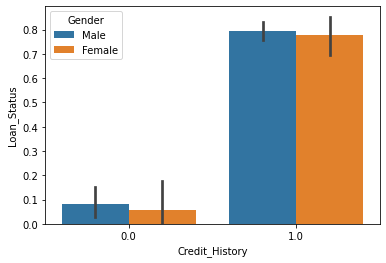

In [32]:
sns.barplot(x='Credit_History',y='Loan_Status',hue='Gender',data=data)

The above chart doesn't show any significant difference between male and females' loan status in the two levels of credit.

<AxesSubplot:xlabel='Education', ylabel='total_income'>

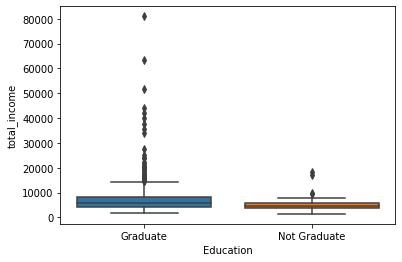

In [33]:
sns.boxplot(x=data.Education, y=data.total_income)

- We can see that this does appear to be true; graduate customers seem to earn more on average.

Let's check how property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='LoanAmount'>

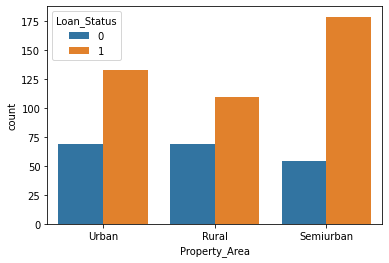

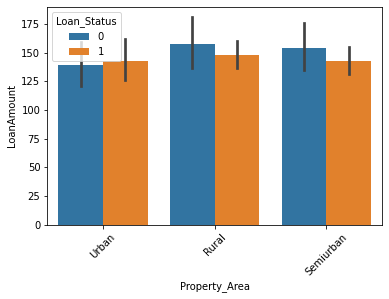

In [34]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)
plt.figure()
plt.xticks(rotation=45)
sns.barplot(x='Property_Area',y='LoanAmount', hue='Loan_Status',data=data)

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- The models we plan to apply cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

In [35]:
# Separating the target variable from the explanatory/independent variables
X= data.drop(columns = ['Loan_Status'])
Y= data['Loan_Status']

In [36]:
# Creating dummy variables 
X = pd.get_dummies(X, drop_first=True)

In [37]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,random_state=1)

In [38]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(429, 13) (185, 13) (429,) (185,)


## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he/she is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [39]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'], cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

In [40]:
#define logistic regression model the model
log_reg=LogisticRegression()

#fit the model on the train dataset using random_state=1
log_reg.fit(X_train,y_train)

LogisticRegression()

**Let's check the coefficient of each dependent variable in the data**

In [41]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.026255
Property_Area_Semiurban    0.821588
Married_Yes                0.189407
Dependents_2               0.154738
Dependents_3+              0.113787
total_income              -0.000010
LoanAmount                -0.000474
Property_Area_Urban       -0.006438
Loan_Amount_Term          -0.065874
Self_Employed_Yes         -0.098511
Gender_Male               -0.106007
Dependents_1              -0.145731
Education_Not Graduate    -0.491750
dtype: float64

**Observations:**

Features with positive effect on the (log odds of) Loan_Status rate are:

- Credit_History (if every other variable is kept unchanged, the change in log-odds for 1-unit increase in Credit_History is equal to 3.026255)
- Property_Area_Semiurban (if every other variable is kept unchanged, the change in log-odds for "Property_Area_Semiurban"=1 relative to to that of a Rural Property_Area, which is the base level here, is 0.821588)     
- Married_Yes                
- Dependents_2               
- Dependents_3+

Features with negative effect on the (log odds of) Loan_Status rate are:

- total_income             
- LoanAmount                
- Property_Area_Urban       
- Loan_Amount_Term          
- Self_Employed_Yes         
- Gender_Male               
- Dependents_1              
- Education_Not Graduate (if every other variable is kept unchanged, the change in log-odds of Loan_Status is -0.491750 for "Education_Not Graduate"=1 relative to "Education_Not Graduate"=0)


#### Interpretation of the odds calculated from the logistic regression model coefficients

In [42]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

# adding the odds to a dataframe and sorting the values
pd.DataFrame(data=odds, index=X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.619861
Property_Area_Semiurban,2.274108
Married_Yes,1.208532
Dependents_2,1.167352
Dependents_3+,1.120513
total_income,0.999990
LoanAmount,0.999526
Property_Area_Urban,0.993583
Loan_Amount_Term,0.936249
Self_Employed_Yes,0.906186


**Observations:** 
Assuming every other variable is kept unchanged, 
- The approval odds of the loan request of a customer with a good credit history is 20.6 times of the request of those without one.
- The odds of a Semiurban property to get a loan granted is 130% more than the odds of one which is rural; In other words, the odds_ratio of Loan_Status for "Property_Area_Semiurban" relative to that of a Rural Property_Area, which is the base level here, is almost 2.3X.
- The odds of married applicants recieving a loan are 1.2 times (20% higher than) the odds of unmarried applicants.
- The odds of an applicant who has two dependents to get a loan approved are 1.17 times the odds of an someone who doesn't have any dependents (base).
- The odds of an applicant who has three or more dependents to get a loan approved are 1.12 times the odds of an someone who doesn't have any dependents (base).
- Not graduating decreases one's odds of getting approved by almost 40%
- Each of the other features has a less than 14% negative effect on receiving loan approval.

**Now, let's check the performance of the model on the training set using classification report and confusion matrix**

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



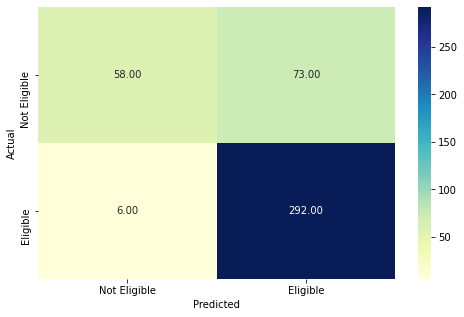

In [43]:
# Predict on the training data 
y_pred_train = log_reg.predict(X_train)

# Checking performance on the training data
metrics_score(y_train, y_pred_train)

**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is not eligible and the customer is actually not eligible
- **False Negative**: Predicting the customer is eligible but the customer is actually not eligible
- **True Negative**: Predicting the customer is eligible and the customer is actually eligible
- **False Positive**: Predicting the customer is not eligible but the customer is actually eligible

**Observations:** We want to try to prevent defaults in order to avoid losses (prevent False Negative)(0:+:not_eligible, 1:-:eligible)
- TP=58, FN=73, TN=292, FP=6
- The accuracy is around 82% on the train dataset.
- However, recall for this model is only around 44% for class 0 (not eligible) on the train data set. This means that, this model will not perform well in differentiating out those loan applicants who have a high chance of default, meaning it will eventually not help in reducing losses that result from default.
- As we can see from the Confusion Matrix, this model fails to identify the majority (56%) of loan applicants who are at risk of defaulting their loan.

**Precision-Recall Curve for Logistic Regression**

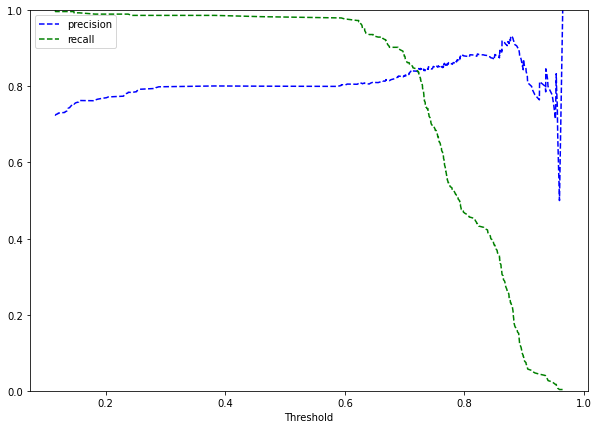

In [44]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [45]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7222044728784354


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

#### Compare the performance of the model on training and testing sets after changing the threshold

              precision    recall  f1-score   support

           0       0.51      0.73      0.60       131
           1       0.85      0.69      0.76       298

    accuracy                           0.70       429
   macro avg       0.68      0.71      0.68       429
weighted avg       0.75      0.70      0.71       429



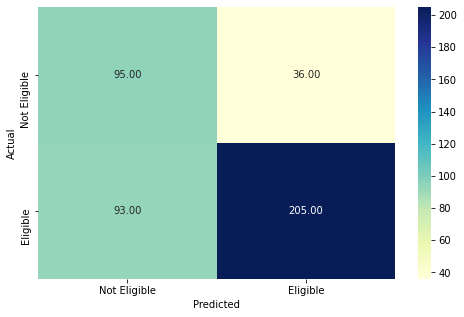

In [46]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        61
           1       0.81      0.74      0.78       124

    accuracy                           0.71       185
   macro avg       0.68      0.70      0.69       185
weighted avg       0.73      0.71      0.72       185



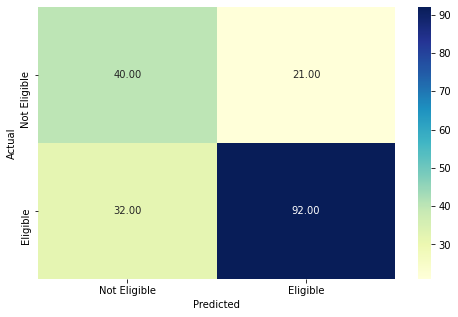

In [49]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

# Kappa Score
# print('KappaScore is: ', metrics.cohen_kappa_score(y_test,y_pred_test))

**Observations:** Goal: try to prevent defaults in order to avoid losses (prevent False Negative)(0:+:not_eli, 1:-:eli)

old threshold train: TP=58, FN=73, TN=292, FP=6
new threshold train: TP=95, FN=36, TN=205, FP=93
new threshold test:  TP=40, FN=21, TN=92, FP=32
- The accuracy is around 70% on both the train and test datasets.
- The recall for this model has improved to 73% (on the train data set) and 66%(on the test data set) for class 0 (not eligible). This means that, this model could perform better in differentiating out those loan applicants who have a high chance of default, meaning there is some hope that it could eventually help in reducing losses that result from defaults.
- As we can see from the Confusion Matrix, this model is weaker in identifying Eliginle applicants, which is the cost we are paying to reach a higher recall.

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [50]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        # Scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.2848837209302325],
 2: [0.11302235179786198, 0.33333333333333326],
 3: [0.15724003887269192, 0.24302325581395348],
 4: [0.16336248785228377, 0.2534883720930233],
 5: [0.18221574344023328, 0.23178294573643415],
 6: [0.18464528668610297, 0.24418604651162787],
 7: [0.19387755102040816, 0.2135658914728683],
 8: [0.19018464528668616, 0.22325581395348842],
 9: [0.1987366375121477, 0.21317829457364348],
 10: [0.19640427599611276, 0.22403100775193802],
 11: [0.20262390670553934, 0.21511627906976755],
 12: [0.20000000000000004, 0.20155038759689922],
 13: [0.20379008746355687, 0.20697674418604659],
 14: [0.19523809523809527, 0.21007751937984492],
 15: [0.20009718172983484, 0.20542635658914732],
 16: [0.1959183673469388, 0.2054263565891473],
 17: [0.1978620019436346, 0.21395348837209305],
 18: [0.1998056365403304, 0.2007751937984496],
 19: [0.20534499514091353, 0.1984496124031008],
 20: [0.19902818270165215, 0.20658914728682173]}

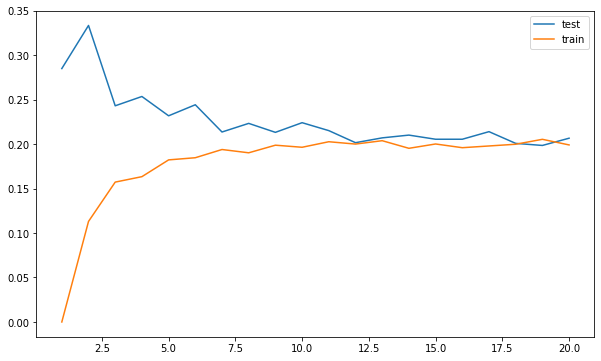

In [51]:
# Extracting k and the test error in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error error
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

- 

- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [52]:
# scaling the data
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [53]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



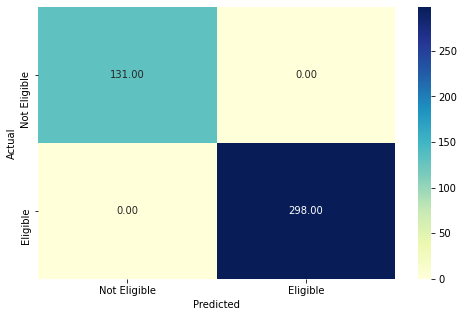

In [54]:
#predict on train data
y_pred_train_knn = knn.predict(X_train_scaled)# write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:**
- The above results show no error had occured in this classification of the trained data. It seems that this model has overfitted our train data (looks too good to be true!). Further investigation of the test data could show how reliable this model is.

              precision    recall  f1-score   support

           0       0.61      0.31      0.41        61
           1       0.73      0.90      0.81       124

    accuracy                           0.71       185
   macro avg       0.67      0.61      0.61       185
weighted avg       0.69      0.71      0.68       185



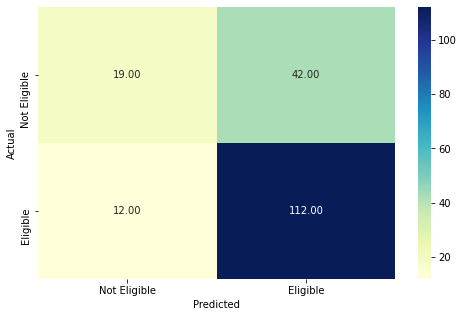

KappaScore is:  0.24535428312433905


In [55]:
#predict on test data
y_pred_test_knn = knn.predict(X_test_scaled)# Write your code here

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

# Kappa Score
print('KappaScore is: ', metrics.cohen_kappa_score(y_test,y_pred_test_knn))

**Observation:**
- As expected, after the model got applied to the test data, a rather different performance revealed itself. 
- Unfortunately, the recall is only 31%, which is worse than what we obtained in the previous models.
- These unfortunate results are probably due to overfitting the model to the training dataset. Hyper-parameters tuning might help in improving the results.
- These results show that this knn model is not a suitable one for this problem.

## Conclusion:

In this problem, our main aim was preventing defaults in order to avoid losses.

The logistic regression model with a threshold of 75% seems more promissing than the rest of the models applied in this study. Its accuracy is around 70% on both the train and test datasets.
The recall for this model has improved to 73% (on the train data set) and 66%(on the test data set) in class of not eligible loan applicants. This model has the potencial to perform better than other models in this study, in differentiating out those loan applicants who have a high chance of default, meaning there is some hope that it could eventually help in reducing losses that result from defaults.

## Recommendations:

In overall, based on the above investigation, it is recommended to focus more (targeting adds, for example) on servicing married customers with higher Credit_History, within the Semiurban areas because these groups have lower odds of defaulting their loans. Having 2 or more dependents would also increase the odds of paying back one's loan.
It is possible to apply the above model directly to the features of a potential customer to predict the odds of him or her defaulting their loan and comparing the result with a threshold of 75% to decide whether or not to grant them a loan.